# Algorithmic Fairness, Accountability, and Ethics, Spring 2024

## Mandatory Assignment 2: Debiasing data and fairer models

### Group random:
 * Constantin-Bogdan Craciun (cocr@itu.dk)
 * Gino Franco Fazzi (gifa@itu.dk)
 * Veron Hoxha (veho@itu.dk)

#### Imports

In [1]:
# Folktables library
from folktables import ACSDataSource, BasicProblem, generate_categories
# Arrays and dataframes libraries
import numpy as np
import pandas as pd
# Statistical and algebra library
import scipy
from scipy.stats import  pearsonr
from scipy.stats import mannwhitneyu
# ML libraries
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, accuracy_score
from sklearn.decomposition import PCA
# Plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

### Functions & Classes

In [2]:
def adult_filter(data):
    """Mimic the filters in place for Adult data.
    Adult documentation notes: Extraction was done by Barry Becker from
    the 1994 Census database. A set of reasonably clean records was extracted
    using the following conditions:
    ((AAGE>16) && (AGI>100) && (AFNLWGT>1)&& (HRSWK>0))
    """
    df = data
    df = df[df['AGEP'] > 16]
    df = df[df['PINCP'] > 100]
    df = df[df['WKHP'] > 0]
    df = df[df['PWGTP'] >= 1]
    df = df[df["RAC1P"] < 3] ## keep only Whites and African-Americans
    return df



class ModelEvaluator:
    """
    Class object to facilitate evaluation of different models. Allows for three types of evalution:
     - Cross-Validation on a given Train set
     - Traditional evaluation given a Train and Test set
     - Bootstrap evaluation given a Train and Test set (i.e., fitting on the train set, and using predicting on multiple resamplings of the test set)
    
    The used metrics are: Accuracy, F1-Score and Positive Rate, discriminated by groups.
    """

    def __init__(self, estimator, groups, random_state = 0):
        """
        The constructor takes an estimator (i.e., a sklearn model with fit and predict methods), 
        a dictionary of groups and their indexes in the data, and a random state for reproducibility.
        """
        self.model = estimator
        self.groups = groups
        self.random_state = random_state


    def fit(self, X, y):
        # Allows to fit the internal model
        self.model.fit(X, y)


    def cross_validate(self, X, y, cv = 5):
        """
        This method allows to perform cross validation on a given train set.
        All results from the different splits are then averaged and compiled by group.
        """

        # Collect the results
        results = {}

        # Create an instance of CV splitter
        kf = KFold(n_splits=cv, random_state= self.random_state, shuffle=True)

        # For each K fold, fit the model and calculate the metrics
        for k, (train_index, test_index) in enumerate(kf.split(X)):

            # Fit model to the specific K split data
            self.model.fit(X[train_index], y[train_index])
            # Predict on the K split test data
            y_hat = self.model.predict(X[test_index])

            # Calculate Scores for each group
            for group, group_idxs in self.groups["train"].items():

                # Retrieve group ids
                group_id = group_idxs.iloc[test_index]

                # If group is not in results, add it
                if group not in results:
                    results[group] = {"f1": [], "accuracy": [], "pos_rate": []}
                
                # Append the k's f1, accuracy and TPR for the given group
                results[group]["f1"].append(f1_score(y[test_index][group_id], y_hat[group_id]))
                results[group]["accuracy"].append(accuracy_score(y[test_index][group_id], y_hat[group_id]))
                results[group]["pos_rate"].append(np.mean(y_hat[group_id]))

        
        # Aggregate CVs results
        for group in self.groups["train"]:

            # Aggregate individual results from folds to mean and standard deviation
            for metric in ["f1", "accuracy", "pos_rate"]:
                avg = np.mean(results[group][metric])
                std = np.std(results[group][metric])
                results[group][f"{metric}_avg"] = avg
                results[group][f"{metric}_std"] = std
                del results[group][metric]

        return pd.DataFrame(results).T
    

    def evaluate(self, X_train, y_train, X_test, y_test):
        """
        Performs a traditional model evaluation given a train and test set.
        """
        
        results = {}

        self.model.fit(X_train, y_train)
        y_hat = self.model.predict(X_test)

        # Calculate and print F1 Scores for each group
        for group, group_idxs in self.groups["test"].items():
            results[group] = {"f1": f1_score(y_test[group_idxs], y_hat[group_idxs]), "accuracy": accuracy_score(y_test[group_idxs], y_hat[group_idxs]), "pos_rate": np.mean(y_hat[group_idxs])}


        # Return the results as DataFrame
        return pd.DataFrame(results).T
    

    def boostrap_evaluation(self, X_train, y_train, X_test, y_test, n = 1000, sample_size = 10000, replacement=True, aggregate_results = True):
        """
        Performs a bootstrap evaluation: For each iteration (n), we sample from the test set a given number of
        observations (sample_size), with or without replacement (replacement), and calculate the metrics on 
        the predictions for the given sample. Then aggregate (average and standard deviation) the results of all iterations
        (if aggregate_results is set to True)
        """

        results = {"Overall": {"f1": [], "accuracy": [], "pos_rate": []}}

        self.model.fit(X_train, y_train)

        for i in range(n):

            # Get sample indexes 
            sample_ids = np.random.choice(range(len(X_test)), size=sample_size, replace=replacement)
            
            y_hat = self.model.predict(X_test[sample_ids])

            # Add overall results
            
            results["Overall"]["f1"].append(f1_score(y_test[sample_ids], y_hat))
            results["Overall"]["accuracy"].append(accuracy_score(y_test[sample_ids], y_hat))
            results["Overall"]["pos_rate"].append(np.mean(y_hat))

            # Calculate Scores for each group
            for group, group_idxs in self.groups["test"].items():

                # Retrieve group ids
                group_id = group_idxs.iloc[sample_ids]

                # If group is not in results, add it
                if group not in results:
                    results[group] = {"f1": [], "accuracy": [], "pos_rate": []}
                
                # Append the k's f1, accuracy and TPR for the given group
                results[group]["f1"].append(f1_score(y_test[sample_ids][group_id], y_hat[group_id]))
                results[group]["accuracy"].append(accuracy_score(y_test[sample_ids][group_id], y_hat[group_id]))
                results[group]["pos_rate"].append(np.mean(y_hat[group_id]))


        if aggregate_results:
            # Aggregate bootstrap results
            for metric in ["f1", "accuracy", "pos_rate"]:
                avg = np.mean(results["Overall"][metric])
                std = np.std(results["Overall"][metric])
                results["Overall"][f"{metric}_avg"] = avg
                results["Overall"][f"{metric}_std"] = std

            for group in self.groups["train"]:

                for metric in ["f1", "accuracy", "pos_rate"]:
                    avg = np.mean(results[group][metric])
                    std = np.std(results[group][metric])
                    results[group][f"{metric}_avg"] = avg
                    results[group][f"{metric}_std"] = std

        return pd.DataFrame(results).T
    


def debias_features(Xs_np, Xs_p, lambda_ = 1):
    """
    Function that applies the proposed geometric method to removes correlations between data and any number of protected variables.
    by He et al. (https://doi.org/10.1145/3375627.3375864)

    """
    assert Xs_np.shape[0]==Xs_p.shape[0]
    
    # Find orthonormal basis of protected features
    orthbasis = scipy.linalg.orth(Xs_p) #px

    # Debias nonprotected features
    Xs_np_debiased = Xs_np - orthbasis @ orthbasis.T @ Xs_np # rj

    # Return debiased nonprotected features
    return Xs_np_debiased + lambda_ * (Xs_np - Xs_np_debiased)


def evaluate_lambda(model, X_train_np, X_train_p, y_train, protected_feat_dict, lambda_range = [0, 1], load_computations = False, seed = 11012008):
    """
    Function to evaluate the effect of different lambdas in debiasiang of a dataset using the geometric method proposed by He et al. (https://doi.org/10.1145/3375627.3375864)
    Arguments:
     - model: The sklearn estimator to evaluate
     - X_train_np: The non-protected features
     - X_train_p: The protected features
     - y_train: The true labels for training
     - protected_feat_dict: Dictionary of protected features in the form <i: feat>, where i is in the index of the feature in X_p and feat is the feature string denomation.
     - lambda_range: Range of lambdas to try
     - load_computations: Load pre-computed results
     - seed: Random state
    """
    if load_computations:
        try:
            results = pd.read_csv("./data/lambda_results.csv")
            return results
        except FileNotFoundError:
            print("Results not found. Proceeding to compute from scratch...")
    
    proceed = input("Evaluation of lambdas requires around ~60GB of memory and might run for a long time. Do you want to proceed? (Y/N)")

    if proceed not in ["Y", "y", "yes", "Yes"]:
        raise Exception("Operation cancelled. Exiting.")
        
    # Collect the metrics of interest
    results = {"lambda": [], "accuracy": [], "f1": []}
    results.update({f"corr_{f}": [] for f in protected_feat_dict.values()})

    # Apply the different lambdas to the geometric method
    for l in np.linspace(lambda_range[0], lambda_range[1], 11):
        print(f"Trying lambda {l}...")
        # If we have saved the computed debiased features, load them

        # Acumulators for each metric
        acum_acc = []
        acum_f1 = []
        acum_corr = {f"corr_{f}": [] for f in protected_feat_dict.values()}

        # Partition the training set for cross-validation
        kf = KFold(n_splits=5, random_state=seed, shuffle=True) # Note: sharing the seed, each lambda is evaluated with the same partitions of data

        # For each partition, we fit the model and calculate metrics
        for i, (train_index, test_index) in enumerate(kf.split(X_train_np)):
            print(f"Fold: {i+1}")
            # Calculate the debiased features for the partition
            X_np_deb = debias_features(X_train_np[train_index], X_train_p[train_index], lambda_ = l)
            # Fit the model with the debiased features
            model.fit(X_np_deb, y_train[train_index])
            # Predict on the testing part of the fold
            y_hat = model.predict(X_train_np[test_index])

            acc = accuracy_score(y_train[test_index], y_hat)
            f1 = f1_score(y_train[test_index], y_hat)

            print(f"Accuracy: {acc}")
            print(f"F1: {f1}")

            # Add the metrics for the fold
            acum_acc.append(acc)
            acum_f1.append(f1)
            
            # Include the correlation metrics between features
            for i, feat in protected_feat_dict.items():
                acum_corr[f"corr_{feat}"].append(compute_correlation_weight(X_np_deb, X_train_p[train_index, i].reshape(-1,1)))

        # Register the metrics for the given lambda (mean of all k-folds)
        results["lambda"].append(l)
        results["f1"].append(np.mean(acum_f1))
        results["accuracy"].append(np.mean(acum_acc))

        for i, feat in protected_feat_dict.items():
            results[f"corr_{feat}"].append(np.mean(acum_corr[f"corr_{feat}"]))
        
    # Returns the results as a DataFrame
    return pd.DataFrame(results).fillna(0)


def compute_correlation_weight(X_np, X_p, alpha = 0.05):
    """
    Function to compute the correlation between a set of not protected and protected features.
    It uses a custom metric:
        The average of the absolute value of the Pearson's correlation between all pairs of Non-Protected vs Protected features.
        Only significant values are considered.
    """

    # Array of correlations    
    corrs = []

    # Bonferroni correction for multiple comparisons
    alpha = alpha / (X_np.shape[1] * X_p.shape[1])

    print(f"Corrected alpha: {alpha}")

    # Compute Pearson correlation between each pair of Non-Protected - Protected features
    for i in range(X_np.shape[1]):
        for j in range(X_p.shape[1]):
            # Correlation of the non-protected feature i with protected feature j
            c, p = pearsonr(X_np[:,i], X_p[:,j])
            # If significant, append the absolute correlation value (to avoid cancelling out)
            if p < alpha:
                corrs.append(abs(c))

    # Return the average of the correlations
    return np.mean(corrs)


class FairPCA:
    """
    Class to perform the Fair PCA projection on a given set of features.
    This is according to Kleindessner approach (https://proceedings.mlr.press/v206/kleindessner23a.html)    
    """

    def __init__(self, Xs, p_idxs, n_components=None):
        """
        Constructor. Arguments:
         - Xs: The array of features to reconstruct.
         - p_idxs: The indeces of the protected attributes
         - n_components: The number of principal components to use in the reconstruction.
         If the n_components is not passed (None), defaults to the squared root of the number 
         of features.
        """
        self.fit(Xs, p_idxs, n_components)
        # If n_components is not provided, default to the squared root of the number of features
        if n_components == None:
            n_components = int(np.sqrt(Xs.shape[1]))


    def fit(self, Xs, p_idxs, n_components):
        """
        Fit method. Reconstructs the features by the FairPCA method, keeping n_components.
        """
        # Extract protected features
        Xs_p = Xs[:, p_idxs]

        # Compute projection matrix (U)
        Z = Xs_p
        #Z = Z - Z.mean(0) # Since we alredy standardised everything, there is not much sense in removing the mean
        R = scipy.linalg.null_space(Z.T @ Xs)
        eig_vals, L = scipy.linalg.eig(R.T @ Xs.T @ Xs @ R)
        self.U = R @ L[:, :n_components]


    def project(self, Xs):
        """
        Projects a set of features to the PCA space. Requires same shape as the Xs passed when fitting.
        """
        return Xs @ self.U


#### Data loading and preparation

In [3]:
# Seed for reproducibility
seed = 11012008

data_source = ACSDataSource(survey_year='2018', horizon='1-Year', survey='person')
acs_data = data_source.get_data(states=["CA"], download=True)

ACSIncomeNew = BasicProblem(
    features=[
        'AGEP',
        'COW',
        'SCHL',
        'MAR',
        'RELP',
        'WKHP',
        'PWGTP',
        'SEX',
        'RAC1P',
    ],
    target='PINCP',
    target_transform=lambda x: x > 25000,    
    group=['SEX', 'RAC1P'],
    preprocess=adult_filter,
    postprocess=lambda x: np.nan_to_num(x, -1),
)

definition_df = data_source.get_definitions(download=True)
categories = generate_categories(features=ACSIncomeNew.features, definition_df=definition_df)
features, labels, groups = ACSIncomeNew.df_to_pandas(acs_data, categories=categories, dummies=True)

# Drop the "redundant" columns
features = features.drop(["RAC1P_White alone", 
                          "SEX_Male", 
                          "SCHL_1 or more years of college credit, no degree",  
                          "MAR_Divorced", 
                          "RELP_Adopted son or daughter",
                          'COW_Working without pay in family business or farm' ], axis = 1) 

# Generate dictionary with indices to protected features
protect_dict = {}
j = 0
print("Columns with the protected features:")
for i, f in enumerate(features.columns):
    if ("RAC1P" in f):
        protect_dict[j] = "RACE"
        j += 1
        print("Column ID: %s" %i, "(%s)"%f)
    if ("SEX" in f):
        protect_dict[j] = "SEX"
        j += 1
        print("Column ID: %s" %i, "(%s)"%f)
        
features.head()

Columns with the protected features:
Column ID: 54 (SEX_Female)
Column ID: 55 (RAC1P_Black or African American alone)


,AGEP,WKHP,PWGTP,"COW_Employee of a private for-profit company or business, or of an individual, for wages, salary, or commissions","COW_Employee of a private not-for-profit, tax-exempt, or charitable organization",COW_Federal government employee,"COW_Local government employee (city, county, etc.)","COW_Self-employed in own incorporated business, professional practice or farm","COW_Self-employed in own not incorporated business, professional practice, or farm",COW_State government employee,...,RELP_Other nonrelative,RELP_Other relative,RELP_Parent-in-law,RELP_Reference person,RELP_Roomer or boarder,RELP_Son-in-law or daughter-in-law,RELP_Stepson or stepdaughter,RELP_Unmarried partner,SEX_Female,RAC1P_Black or African American alone
0,21,20.0,52,False,False,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False
1,65,8.0,33,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,33,40.0,53,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,18,18.0,106,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
4,27,50.0,23,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


### Pre-processing steps

We split the data to set aside a hold-out dataset to use only when reporting the final metrics for the models. Furthermore, we scale the features and dibide the dataset according to their features: protected and not protected.

In [4]:
# Split dataset into train and test sets
X_train, X_test, y_train, y_test, group_train, group_test = train_test_split(
    features.values, labels.values.reshape(-1), groups, test_size=0.3, random_state=0, shuffle=True)

# Boolean masks for different protected classes
group_dict = {"train": {}, "test": {}}
for k in group_dict:
    group_dict[k] = {
    'Males': eval(f"group_{k}")['SEX'] == 1,
    'Females': eval(f"group_{k}")['SEX'] == 2,
    'Whites': eval(f"group_{k}")['RAC1P'] == 1,
    'African-Americans': eval(f"group_{k}")['RAC1P'] == 2
}

# Scale all features (even OHE)
scaler = StandardScaler().fit(X_train)
Xs_train = scaler.transform(X_train)
Xs_test = scaler.transform(X_test)

# Subset for protected and non-protected features
Xs_train_p = Xs_train[:, 54:]
Xs_test_p = Xs_test[:, 54:]
Xs_train_np = Xs_train[:, :54]
Xs_test_np = Xs_test[:, :54]

## Selected Model: Logistic Regression without regularization

In [5]:
model = LogisticRegression(solver="newton-cholesky", penalty=None, max_iter=1000)

# 1. Classification model trained on the raw dataset

We begin by training a simple Logistic regression binary classifier on the raw (potentially biased) dataset, and reporting key performance metrics, discrimanated by each protected attribute class: 
- Gender (men vs. women)
- Race (white vs. black)

### Evaluating the model using cross validation.

In [6]:
# Create an instance of the Model Evaluator class
me = ModelEvaluator(estimator=model, groups= group_dict, random_state=seed)

# Check results on the raw dataset by Cross-Validation
me.cross_validate(Xs_train_np, y_train, cv=5)

,f1_avg,f1_std,accuracy_avg,accuracy_std,pos_rate_avg,pos_rate_std
Males,0.893827,0.001517,0.840208,0.001980,0.769019,0.003267
Females,0.852506,0.003616,0.800947,0.004386,0.722396,0.003406
Whites,0.877536,0.001840,0.823822,0.002206,0.749263,0.002300
African-Americans,0.846575,0.005342,0.794013,0.007024,0.717696,0.008775


# 2. Classification model trained on the "fairer" versions of the dataset

### Geometric approach

Using He et al.'s geometric method that removes correlations between data and protected variables, we compute a “fairer” (reprojected) version of the dataset. We then use this dataset to train and evaluate a logistic regression classifier.

### First, we evaluate the debiasing method for various lambdas.

In [7]:
lambda_results = evaluate_lambda(model = model, X_train_np = Xs_train_np, X_train_p = Xs_train_p, y_train = y_train, 
                protected_feat_dict = protect_dict, lambda_range = [0, 1], load_computations=True)

lambda_results

,lambda,accuracy,f1,corr_SEX,corr_RACE
0,0.0,0.820539,0.874981,0.000000,0.000000
1,0.1,0.820947,0.875220,0.019289,0.000000
2,0.2,0.821212,0.875367,0.019248,0.017633
3,0.3,0.821355,0.875427,0.022129,0.020609
4,0.4,0.821576,0.875544,0.025544,0.023529
5,0.5,0.821708,0.875604,0.028358,0.024430
6,0.6,0.821896,0.875709,0.030789,0.025856
7,0.7,0.821829,0.875644,0.032172,0.026574
8,0.8,0.821863,0.875654,0.033843,0.028148
9,0.9,0.821863,0.875639,0.035636,0.031033


### Plot the effect of different lambdas in the metrics and correlation between features

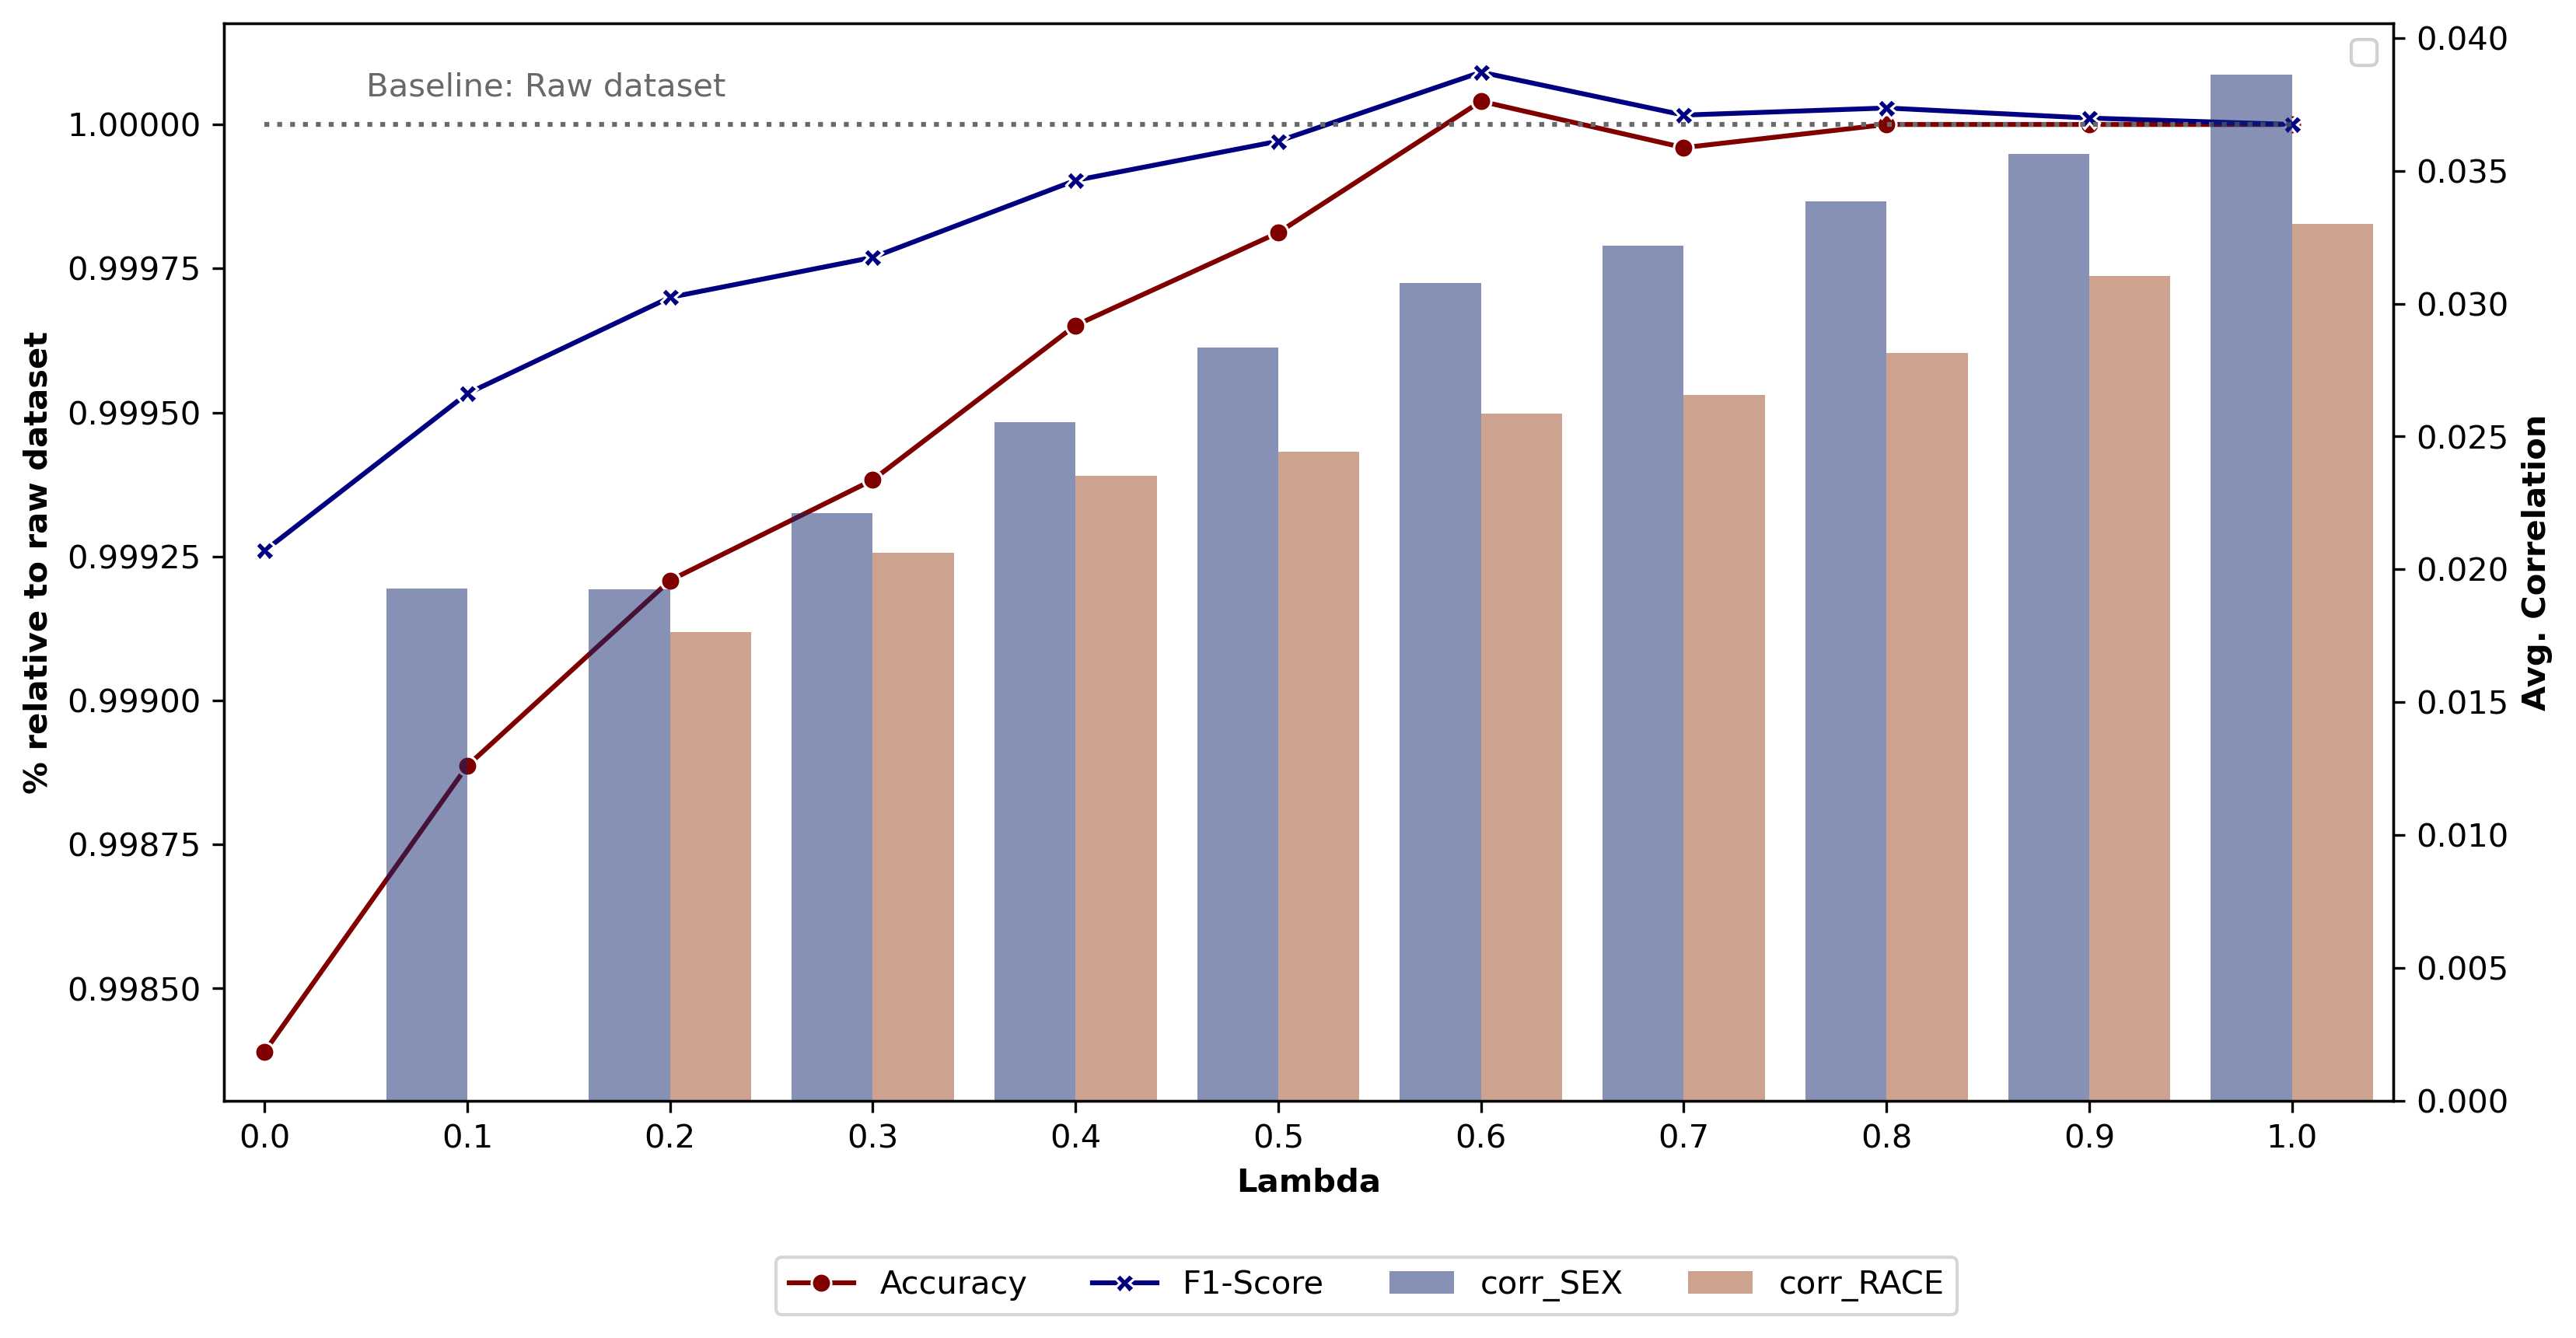

In [8]:
# Reshape the dataframe to plot
_ = pd.melt(lambda_results, id_vars=['lambda', "accuracy", "f1"], value_vars=['corr_SEX', "corr_RACE"])
# Calculate the accuracy and f1 relative to the raw
acc = lambda_results["accuracy"] / lambda_results.loc[10, "accuracy"]
f1 = lambda_results["f1"] / lambda_results.loc[10, "f1"]

# Make a plot
fig, ax1 = plt.subplots(figsize=(12,6), dpi=300)

sns.lineplot(data = acc, marker='o', sort = False, ax=ax1, label="Accuracy", color="maroon")
sns.lineplot(data = f1, marker='X', sort = False, ax=ax1, label="F1-Score", color="navy")
ax2 = ax1.twinx()

sns.barplot(x = _['lambda'], y = _['value'], alpha=0.5, ax=ax2, hue=_["variable"], palette="dark")
ax1.hlines(1, 0, 10, linestyles="dotted", colors="dimgray")
ax1.text(x=0.5, y=1.00005, s="Baseline: Raw dataset", color="dimgray")
plt.xlim(-0.2,10.5)
ax2.set_xticklabels([f"{l:.1f}" for l in lambda_results["lambda"]])
ax1.set_xlabel("Lambda", weight="bold")
ax1.set_ylabel("% relative to raw dataset", weight="bold")
ax2.set_ylabel("Avg. Correlation", weight="bold")
ax1.legend("")
ax2.legend("")
fig.legend(ncol=4, bbox_to_anchor=(0.75, 0.01));

In [9]:
# Get the debiased dataset from the geometric method
try:
    X_test_debiased_geo = np.load("./data/temp/x_debiased_0.0.npy") # We load the pre-computed array from HPC
except:
    print("WARNING: This process requires ~60GB of memory and may take several minutes...")
    X_test_debiased_geo = debias_features(Xs_train_np, Xs_train_p)

me.cross_validate(X_test_debiased_geo, y_train, cv=5)

,f1_avg,f1_std,accuracy_avg,accuracy_std,pos_rate_avg,pos_rate_std
Males,0.889214,0.002742,0.835470,0.003924,0.749103,0.002669
Females,0.850052,0.003183,0.792992,0.003887,0.753343,0.000691
Whites,0.873438,0.002108,0.817730,0.002812,0.750799,0.002136
African-Americans,0.844494,0.005230,0.785483,0.005956,0.754852,0.012092


### FairPCA for fair representation learning

In fair PCA, the authors (Kleindessner et al. - https://proceedings.mlr.press/v206/kleindessner23a.html) aim to remove demographic information when projecting the dataset onto the k-dimensional linear subspace. We look for a best-approximating projection such that the projected data does not contain demographic information anymore.

We use this same approach to create a debiased representation of our datasets features.

In [11]:
# Create the FairPCA instance
fair_pca = FairPCA(Xs_train, [54, 55], int(Xs_train.shape[1]/4))
# Project the 
Xs_train_debiased_PCA = fair_pca.project(Xs_train)
Xs_test_debiased_PCA = fair_pca.project(Xs_test)

In [13]:
me.cross_validate(Xs_train_debiased_PCA, y_train, cv=5)

,f1_avg,f1_std,accuracy_avg,accuracy_std,pos_rate_avg,pos_rate_std
Males,0.874893,0.002064,0.813595,0.002418,0.754015,0.005792
Females,0.825699,0.002360,0.756090,0.003125,0.772115,0.002540
Whites,0.854864,0.002114,0.789146,0.002682,0.763445,0.002591
African-Americans,0.819220,0.010469,0.751860,0.012085,0.748379,0.010101


#### Estimate the variance explained by using regular PCA as a proxy

In [14]:
regularPCA = PCA(n_components = int(Xs_train.shape[1]/4))

regularPCA.fit(Xs_train)

var_explained = regularPCA.explained_variance_ratio_

var_explained.sum()

0.3447563622891217

## 3. Comparing models on the test set

We compare the model trained on the three different versions of the data, using the hold-out test set and a bootsrap approach for robustness.

In [15]:
# Calculate the results for each different trained model
result_raw = me.boostrap_evaluation(Xs_train_np, y_train, Xs_test_np, y_test, n=10000, sample_size=5000, aggregate_results=True)
result_geo = me.boostrap_evaluation(X_test_debiased_geo, y_train, Xs_test_np, y_test, n=10000, sample_size=5000, aggregate_results=True)
result_pca = me.boostrap_evaluation(Xs_train_debiased_PCA, y_train, Xs_test_debiased_PCA, y_test, n=10000, sample_size=5000, aggregate_results=True)

# Gather results
models = {"Raw": result_raw, "Geometric": result_geo, "FairPCA": result_pca}

# Make a full dataframe with all results
all_results = pd.DataFrame()

for m in models:
    _ = models[m].reset_index()
    _.rename({"index": "Group"}, axis=1, inplace=True)
    _["Model"] = m
    all_results = pd.concat([all_results, _])

all_results.head()

,Group,f1,accuracy,pos_rate,f1_avg,f1_std,accuracy_avg,accuracy_std,pos_rate_avg,pos_rate_std,Model
0,Overall,"[0.8737536862800168, 0.8758024002232765, 0.874...","[0.8202, 0.822, 0.8184, 0.811, 0.82, 0.8166, 0...","[0.7414, 0.7458, 0.7516, 0.7432, 0.741, 0.7438...",0.871619,0.004195,0.816718,0.005451,0.745365,0.006183,Raw
1,Males,"[0.891891891891892, 0.8906016907011437, 0.8931...","[0.8382671480144405, 0.8351442487823155, 0.838...","[0.7631768953068592, 0.7710753091045335, 0.771...",0.891965,0.00521,0.838406,0.007157,0.763649,0.008336,Raw
2,Females,"[0.8485052065838092, 0.8568702290076335, 0.851...","[0.7977578475336323, 0.806949806949807, 0.7962...","[0.7143497757847533, 0.7168597168597168, 0.729...",0.845804,0.006889,0.791928,0.008375,0.724468,0.009258,Raw
3,Whites,"[0.8760504201680673, 0.8777149657839929, 0.876...","[0.823050556983719, 0.823869723591172, 0.81974...","[0.7422879177377892, 0.7469466466680952, 0.757...",0.873703,0.004308,0.818809,0.005629,0.747762,0.006378,Raw
4,African-Americans,"[0.8402625820568927, 0.8468468468468469, 0.840...","[0.7801204819277109, 0.7957957957957958, 0.8, ...","[0.7289156626506024, 0.7297297297297297, 0.664...",0.839414,0.018841,0.787096,0.022593,0.711392,0.025186,Raw


### Plot the results for each metric

[Text(0, 0, 'Raw'), Text(1, 0, 'Geometric'), Text(2, 0, 'FairPCA')]

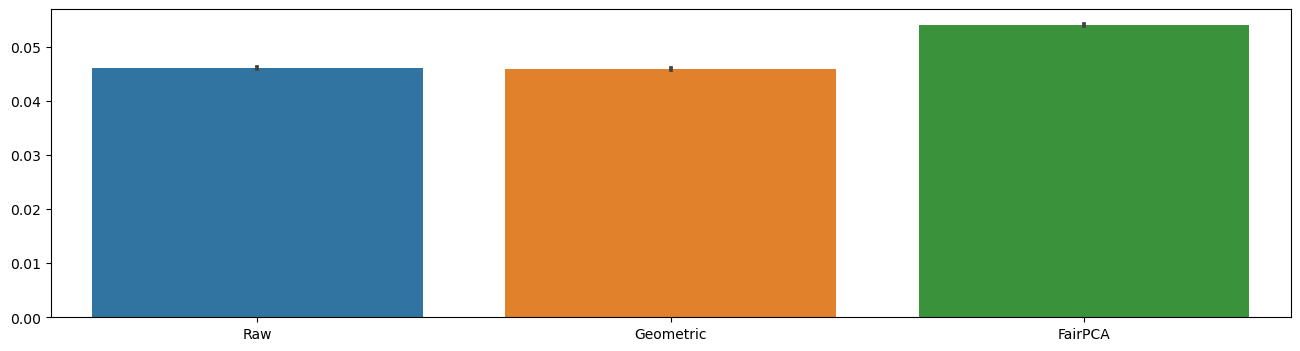

In [16]:
differences_models = {}

for metric in ["f1", "pos_rate"]:

    differences_models[metric] = {}

    for cat in [("Males", "Females"), ("Whites", "African-Americans")]:

        differences_models[metric][f"{cat[0]} vs {cat[1]}"] = {}

        for model in ["Raw", "Geometric", "FairPCA"]:
        
            c1 = all_results.loc[(all_results.Group == cat[0]) & (all_results.Model == model), metric].explode(metric)
            c2 = all_results.loc[(all_results.Group == cat[1]) & (all_results.Model == model), metric].explode(metric)
            diff = c1-c2
            differences_models[metric][f"{cat[0]} vs {cat[1]}"][model] = diff.values

fig, ax = plt.subplots(figsize=(16,4))
_ = pd.DataFrame(differences_models["f1"]).reset_index()
sns.barplot(data=_.iloc[:, 1])
ax.set_xticklabels(_.iloc[:, 0])

### Are these different significant?
To test for significance in the differences in metrics results for each group, we run a (non-parametric) Mann–Whitney U test.

In [17]:
# Bonferroni corrected alpha
# Comparisons 3 models x 4 groups x 3 metrics
bon_alpha = 0.05 / (3 * 4 * 3)

# Compare
for m1 in range(len(models)):
    for m2 in range(m1+1, len(models)):
        mod1_k = list(models.keys())[m1]
        mod2_k = list(models.keys())[m2]
        mod1 = models[mod1_k]
        mod2 = models[mod2_k]
        print(f"### Comparing Model {mod1_k} results to Model {mod2_k} results ###")
        for g in ["Males", "Females", "Whites", "African-Americans"]:
            print(f"\tGroup {g}")
            for metric in ["f1", "accuracy", "pos_rate"]:
                diff = abs(np.mean(mod1.loc[g, metric]) - np.mean(mod2.loc[g, metric]))
                p = mannwhitneyu(mod1.loc[g, metric], mod2.loc[g, metric])[1]
                print(f"\t\tMetric Analyzed: {metric}")
                print(f"\t\t\t{mod1_k}: {np.mean(mod1.loc[g, metric]):.2f} - Model {mod2_k}: {np.mean(mod2.loc[g, metric]):.2f} | Diff.: {diff:.2f} | P-Value {p:.4f} | {p < bon_alpha}")
        print()

### Comparing Model Raw results to Model Geometric results ###
	Group Males
		Metric Analyzed: f1
			Raw: 0.89 - Model Geometric: 0.89 | Diff.: 0.00 | P-Value 0.0000 | True
		Metric Analyzed: accuracy
			Raw: 0.84 - Model Geometric: 0.84 | Diff.: 0.00 | P-Value 0.0000 | True
		Metric Analyzed: pos_rate
			Raw: 0.76 - Model Geometric: 0.76 | Diff.: 0.00 | P-Value 0.0000 | True
	Group Females
		Metric Analyzed: f1
			Raw: 0.85 - Model Geometric: 0.85 | Diff.: 0.00 | P-Value 0.0001 | True
		Metric Analyzed: accuracy
			Raw: 0.79 - Model Geometric: 0.79 | Diff.: 0.00 | P-Value 0.0000 | True
		Metric Analyzed: pos_rate
			Raw: 0.72 - Model Geometric: 0.73 | Diff.: 0.01 | P-Value 0.0000 | True
	Group Whites
		Metric Analyzed: f1
			Raw: 0.87 - Model Geometric: 0.87 | Diff.: 0.00 | P-Value 0.0000 | True
		Metric Analyzed: accuracy
			Raw: 0.82 - Model Geometric: 0.82 | Diff.: 0.00 | P-Value 0.0000 | True
		Metric Analyzed: pos_rate
			Raw: 0.75 - Model Geometric: 0.75 | Diff.: 0.00 | P-Value 